# Remove Image Backgrounds with Python

### Tutorial by _Tobias Reaper_

---

### Notes

* Please do not request access to this tutorial. You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself.


### Resources and related content

* [Trash Panda](https://tobias.fyi/workshop/trash-panda/)
* [Two Shots to Green Screen: Collage with Deep Learning](https://app.wandb.ai/stacey/greenscreen/reports/Two-Shots-to-Green-Screen%3A-Collage-with-Deep-Learning--VmlldzoxMDc4MjY)



---
---

## Introduction

Header Image

<img src="https://raw.githubusercontent.com/tobias-fyi/assetstash/master/visual/images/img_seg_bin_mask/07_paws_header_crop.jpg"/>

### Intro (for post description)

Use Python to programmatically create image masks, use masks to extract, remove, or manipulate parts of an image, and transform and combine multiple images.

### TL;DR

The goal of this tutorial is to describe one method of automating the process of cutting out objects (things, people, pets, etc.) from images and combining them to make a collage of sorts.

First, I go through creating binary masks for one or more objects in an image by using a class of computer vision algorithms called image segmentation. Binary mask(s) in hand(s), I go through one method (technically two, actually) of using said binary mask(s) to extract or remove part(s) of an image. Next, I do some basic image transformations (rotate, crop, and scale) on the resulting cutout. Finally, I paste the cutout on top of another image to make a collage.

Rather than drawing binary masks by hand or using proprietary software like Photoshop to manipulate and transform images, I will show you how to automate the process using completely free, open-source tools. Namely, we'll be using Python along with a few open-source libraries:

* [NumPy](https://numpy.org/)
* [OpenCV](https://opencv.org/) ([opencv-python](https://pypi.org/project/opencv-python/))
* [PyTorch](https://pytorch.org/) ([Detectron2](https://github.com/facebookresearch/detectron2))
* [Pillow](https://pillow.readthedocs.io/)

---

## The Problem

Selecting and separating parts of an image can be a tedious, time-consuming process. Anyone who's done a fair amount of tinkering with image manipulation using a program like Photoshop knows the struggle.

Although modern tools make the process easier, wouldn't it be nice if there was a way to automate the process?

As an example, say I'd like to cut out my cat Hobbes from a photo in order to "Photoshop" him into a different image. Here's the photo of Hobbes I'll be using.

<img src="https://raw.githubusercontent.com/tobias-fyi/assetstash/master/visual/images/img_seg_bin_mask/01_hobbes.jpg" width=300 />

I think his position is perfect for creating "Hawbbes" (Jaws + Hobbes)...meh I'll call it "Paws". By cutting him out and rotating him a bit, he could be pasted onto an underwater shot of someone swimming and he could live his dream of being a fierce sharkitty.

Here's an image I found on [Unsplash](https://unsplash.com/photos/wNynGAQAC10) that would work as the background onto which Hobbes, once cut out of the image above, can be pasted.

<img src="https://raw.githubusercontent.com/tobias-fyi/assetstash/master/visual/images/img_seg_bin_mask/05_jaws_kinda.jpg" width=300 />

Basically, in order to cut Hobbes out of the photo above, I'll have to make all the pixels in the image transparent except for the ones representing Hobbes. Then I'll crop, rotate, scale, and superimpose the resulting image on top of the underwater shot such that Hobbes roughly takes up the bottom half.

---
---

## Solution

### Image Masking

To accomplish this manually, I could spend anywhere from a few minutes to a few hours outlining Hobbes in the original image to create a mask — masking the image. The time investment depends on how easily-separable the subject is from the rest of the image, how accurate I want the cut to be, and what tools are available to me.

Regarding that last point, the magicians at Adobe have done some rather impressive black magic with Photoshop, giving users very quick and very effective methods for selecting parts of an image. However, the goal of this post is to accomplish this programmatically, without the use of any closed-source software.

A mask is basically a method of distinguishing/selecting/separating pixels. If you've never heard the term used this way before, one way to think about it is with masking tape and paint. Typically, one would put masking tape—i.e. create a "mask"—around areas on a wall that should _not_ be painted. This is essentially what a mask is doing in any photo manipulation software: indicating what areas of an image to affect or transform (or which areas not to do so).

Here's the image of Hobbes with the image segmentation-generated masks overlayed on top of it (which we'll be creating later) showing, obviously, where Hobbes is in the image. It doesn't really matter that the model thinks he's a dog — we won't be using the predicted class, only the mask. And the mask is still good enough for our purposes.

<img src="https://raw.githubusercontent.com/tobias-fyi/assetstash/master/visual/images/img_seg_bin_mask/02_hobbes_mask_overlay.png" width=300 />

A binary mask is a method of masking which uses a two-tone color scheme, to indicate the areas of an image to be affected and not affected. By overlaying a binary mask on top of the original image, the boundaries between the two colors can be used to affect the different areas of the image differently, whether that is making pixels transparent (removing them) or applying some sort of effect or transformation.

The white area in the image below shows the same coordinates as the orange one above, converted into a binary mask. While I've only spent any significant time with Photoshop, I'd imagine any decent image manipulation software can work with binary masks similarly to how we'll be working with them.

<img src="https://raw.githubusercontent.com/tobias-fyi/assetstash/master/visual/images/img_seg_bin_mask/03_hobbes_bin_mask.png" width=300 />

### Computer vision

In order to generate binary masks based on the content of the image, the algorithm must be somewhat intelligent. That is, it must be able to process the image in such a way that it can recognize where the foreground is and draw a polygon around it with some degree of accuracy.

Luckily, there are a number of deep learning models that will do just that. The field is called Computer Vision, and the class of algorithm used in this article is known as image segmentation.

Don't worry if you don't have any experience with this type of thing, or even if you don't necessarily want to _get_ experience with it. Modern machine learning tooling makes it incredibly quick and easy to get a model up and predicting with pre-trained weights. Though if you want to understand what's going on, it will likely help to know a bit of Python programming.

One caveat: the pre-trained models will usually work well with classes of objects that were in their training data. The model weights used in this post were trained on the [COCO](https://cocodataset.org/) dataset, which contains 80 object classes. Depending on what the object in the foreground is that you are trying to extract, you may or may not need to extend the model with a custom dataset and training session. That is a topic for another post.

#### Detectron2

The deep learning framework used here is PyTorch, developed by [Facebook AI Research](https://github.com/facebookresearch) (FAIR). More specifically, we'll use a computer vision framework, also developed by FAIR, called [Detectron2](https://github.com/facebookresearch/detectron2).

Although the primary framework used in this article is Detectron2, this process should be translatable to other image segmentation models as well. In fact, I'll be adding an addendum to this post in which I'll go over using Matterport's TensorFlow-based implementation of Mask R-CNN to accomplish the exact same thing.

> TODO: Also do this with [fastai](https://docs.fast.ai/vision.image.html#ImageSegment)?

### End Result

I know you've been dying to see the end result of the whole process. Without any further ado, I present to you, Paws!

<img src="https://raw.githubusercontent.com/tobias-fyi/assetstash/master/visual/images/img_seg_bin_mask/06_paws.jpg" width=300/>

With that, let's get into how this masterpiece was created.

---
---

## Setup

### Install Detectron2 and other dependencies

As mentioned in the introduction, the framework we'll be using for image segmentation is called Detectron2. The following cells install and set up Detectron2 in a Google Colab environment (pulled from the [official Detectron2 getting started notebook](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5)). If you don't want to use Colab for whatever reason, either play around with installation and setup or refer to the [installation instructions](https://detectron2.readthedocs.io/tutorials/install.html).

The other top-level dependencies needed for this tutorial:

* [NumPy](https://numpy.org/)
* [OpenCV](https://opencv.org/) ([opencv-python](https://pypi.org/project/opencv-python/))
* [Pillow](https://pillow.readthedocs.io/)

The nice thing about Colab is all of these come pre-installed. Oh yeah, you also get free access to a GPU. Thanks, Google!

Again, simply click the "Open in Colab" badge at the top of this page, then hit File > Save a copy in Drive, which does exactly what it says: saves a copy of the notebook to your Google Drive. In addition, you can open an ephemeral copy of the notebook without saving it first by hitting File > Open in playground mode.

In [1]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.5.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Install detectron2 (colab has CUDA 10.1 + torch 1.5)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.5")
!pip install detectron2==0.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.9MB 2.9MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200716-cp36-none-any.whl size=42325 sha256=ca3d54b3906bce076edda2e61cb520b8608ed9cfd62b59c3fa390a60b4a591ac
  Stored in directory: /root/.cache/pip/wheels/81/99/f4/42a6bef61c07b3d78dfe6d7ebff259444c4526504cf72378d7
Successfully built fvcore


Once you have everything installed, we can start with some imports and configuration.

In [3]:
# === Some imports and setup === #

# Setup Detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Common libraries
import numpy as np
import os, json, cv2, random
# Only needed when running in Colab
from google.colab.patches import cv2_imshow

# Detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

---
---

## Running a pre-trained Detectron2 model

Most, if not all, open-source deep learning frameworks have a set of pre-trained weights available to use. The creators of the frameworks will conduct a series of training sessions on the most commonly-used datasets in order to benchmark the performance of their algorithms. Luckily for everyone else, they typically provide the results of this training in the form of weights, which can be loaded into the model and be used for inference immediately.

For many tasks, including recognizing and outlining an image of a cat, pre-trained weights will work fine. The model weights used in this post were trained on the popular [COCO](https://cocodataset.org/) dataset, which contains 80 object classes, including cats. If, for example, we wanted to do the same thing with whales or one specific person, custom training would be necessary.

I will be publishing a companion blog post to this one about training Detectron2 on a custom dataset. Once that is published, I'll link to it here. If there's no link yet, I haven't published it yet.

If you're curious about custom training now, the Detectron2 "Getting Started" [Colab notebook](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5) also goes through one way of doing so.

### Image loading and image arrays

The first thing we need in order to use the model is an image on which it can be used.

We first download the image to the local filesystem using `wget`, then load it into an array using cv2 (opencv-python).

In [4]:
# === Download and load image === #
!wget https://raw.githubusercontent.com/tobias-fyi/assetstash/master/visual/images/img_seg_bin_mask/01_hobbes.jpg -q -O 01_hobbes.jpg
im = cv2.imread("./01_hobbes.jpg")

If you think about what a digital image actually is, it makes sense to represent it as a matrix — each row corresponds to a row of pixels, and each column a column of pixels in the image. Technically, images would be considered a 3-dimensional array, because they have width, height, and depth (number of channels).

Depending on if the image has three channels (typically RGB: red, green, blue) or four (typically RGBA: same plus an alpha channel), the values at each row-column index (or cell, like in a spreadsheet, in case that helps you visualize it) indicate the intensities of each of the color channels (and transparency, in the case of 4-channel images) for each pixel.

Thus, after the image is loaded, it really is just an array of numbers and can be utilized and manipulated just like any other array. For example, in order to rotate the image, a [linear transformation](https://en.wikipedia.org/wiki/Transformation_matrix) can be applied to the image matrix to "rotate" the pixel values within the matrix.

Here is an example of a single row in the array representing the image of Hobbes is shown.

In [5]:
# === Look at the image, in array form === #
print("Image dimensions:", im.shape)
print("\nImage array - first row of 3-value sub-arrays:")
im[0]

Image dimensions: (800, 600, 3)

Image array - first row of 3-value sub-arrays:


array([[172, 192, 209],
       [188, 208, 225],
       [119, 137, 154],
       ...,
       [137, 151, 149],
       [139, 153, 151],
       [142, 156, 154]], dtype=uint8)

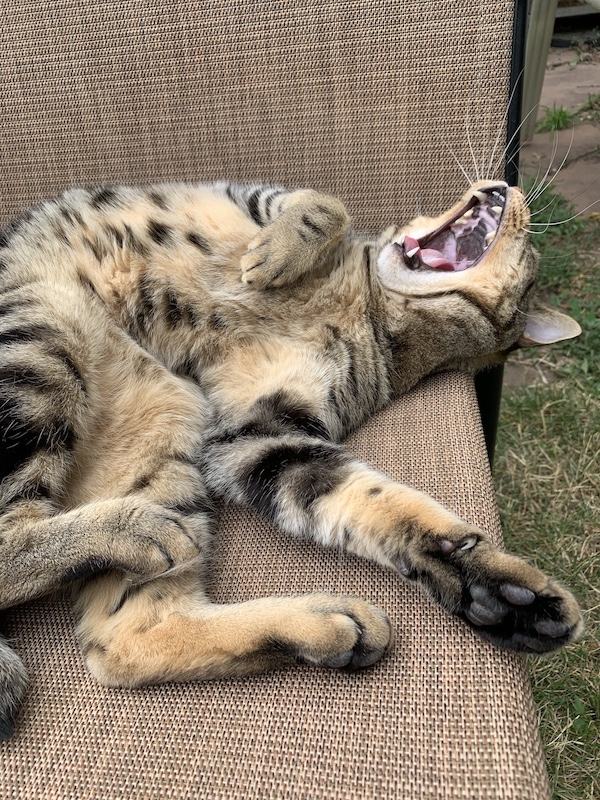

In [6]:
# === Look at the image, rendered === #
cv2_imshow(im)

---

### Inference with Detectron2

After the image is loaded, we're ready to use Detectron2 to run inference on the image and find the mask of Hobbes. Running inference means generating predictions from the model. In the case of image segmentation, the model is making a prediction for each pixel, providing its best guess at what class of object each one belongs to, if any.

We create a Detectron2 config and instantiate a `DefaultPredictor`, which is then used to run inference.

Just a heads-up: the first time this runs, it will automatically attempt to start downloading the pre-trained weights — a ~180mb pickle file. That's a lot of pickles...

In addition to downloading and configuring the weights, the threshold is set for the minimum predicted probability. In other words, the model will only output a prediction if it is certain enough — the probability assigned to the prediction is above the threshold.

In [7]:
# === Set up config and run inference === #

# Add project-specific config (e.g., TensorMask) here if you're
# not running a model in Detectron2's core library
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_f10217.pkl: 178MB [00:19, 9.33MB/s]                           


By default, the output of the model contains a number of results, including the predicted classes, coordinates for the bounding boxes (object detection), and mask arrays (image segmentation), along with various others, such as pose estimation (for people). More information on the types of predictions made by Detectron2 can be found in the [documentation](https://detectron2.readthedocs.io/tutorials/models.html#model-output-format).

We are really only interested in the one mask and bounding box surrounding Mr. Hobbes here, though will also need to extract the IDs for the predicted classes in order to select the correct mask and bounding box. If the image only has one type of object, then this part isn't really necessary. But when there are many different classes in a single image, it's important to be certain which object we are extracting.

First, let's take a look at how the model did.

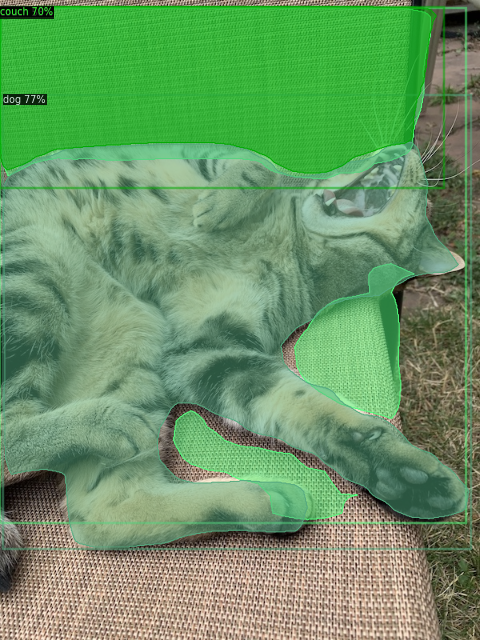

In [8]:
# `Visualizer` draws the predictions on the image
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

---

### Extracting the mask and bounding box

The "dog" is the first id in the `.pred_classes` list. Therefore, the mask and bounding box that we want is the first one in the `.pred_masks` list.

Those colored areas are the "masks", which can be extracted from the output of the model and used to manipulate the image in neat ways. First, we'll need to get the array(s) holding the mask(s).

In this case, as can be seen below, each mask is a 2-dimensional array of Boolean values, each one representing a pixel. If a pixel has a "True" value, that means it is inside the mask, and vice-versa.

In [9]:
# Look at the outputs - classes, masks, bounding boxes
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_masks)

tensor([16, 57, 57], device='cuda:0')
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False, 

In [10]:
# === Find out what the class IDs correspond to ===

# List of all classes in training dataset (COCO)
# predictor.metadata.as_dict()["thing_classes"]

# The one we are interested in
predictor.metadata.as_dict()["thing_classes"][16]

'dog'

In [11]:
# === Extract (only) the mask of Hobbes === #
# Find the index of the class we are interested in
# First, convert to numpy array to allow direct indexing
class_ids = np.array(outputs["instances"].pred_classes.cpu())
class_index = np.where(class_ids == 16)  # Find index where class ID is 16
# Use that index to index the array of masks
mask_tensor = outputs["instances"].pred_masks[class_index]
print(mask_tensor.shape)
mask_tensor

torch.Size([1, 800, 600])


tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')

In [21]:
# Convert tensor to numpy array
hobbes_mask = mask_tensor.cpu()
print("Before:", type(hobbes_mask))
print(hobbes_mask.shape)
hobbes_mask = np.array(hobbes_mask[0])
print("After:", type(hobbes_mask))
print(hobbes_mask.shape)

Before: <class 'torch.Tensor'>
torch.Size([1, 800, 600])
After: <class 'numpy.ndarray'>
(800, 600)


In [22]:
hobbes_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

---

### Converting to a binary mask

Now that we've run inference on the image and retrieved the mask array, it's time to turn that array into a binary mask. While I won't be using this particular binary mask directly, it can be downloaded as a png and/or edited and used to various ends.

In [23]:
# Create blank black background
# The "True" pixels will be converted to white and copied onto the black background
background = np.zeros(hobbes_mask.shape)
background.shape

(800, 600)

In [24]:
# Add white pixels where mask values are True
bin_mask = np.where(hobbes_mask, 255, background).astype(np.uint8)
print(bin_mask.shape)
bin_mask

(800, 600)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

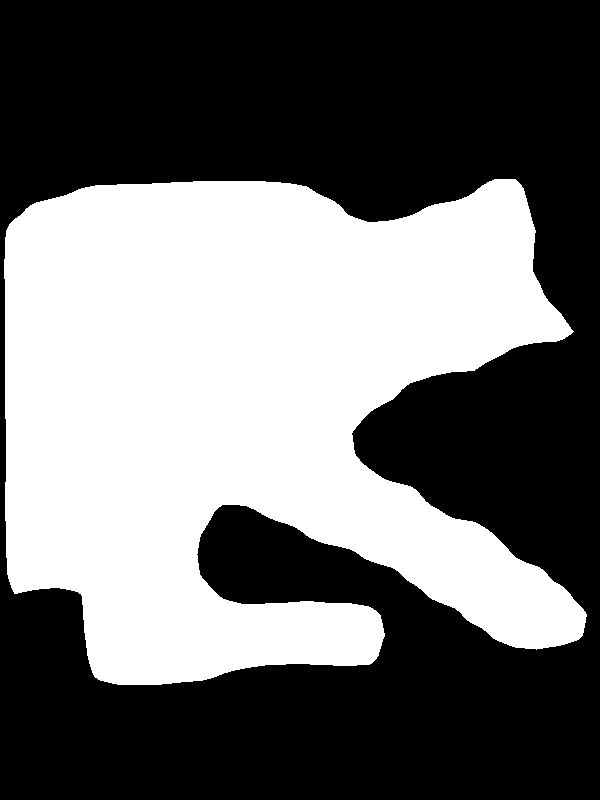

In [25]:
# Show the resulting binary mask
cv2_imshow(bin_mask)

---

### Using the binary mask to cut out Hobbes

In order to use numpy operations between the mask and image, the dimensions of the mask must match the image. The image array has three values for each pixel, indicating the values of red, green, and blue (RGB) that the pixel should render. Therefore, the mask must also have three values for each pixel. To do this, I used a NumPy method called `np.stack` to basically "stack" three of the masks on top of one another.

Once the dimensions match, another NumPy method, `np.where`, can be used to copy or extract only the pixels contained within the area of the mask. I created a blank background onto which those pixels are copied.

In [26]:
# === Add a fourth channel to the original image array === #

# Split into RGB (technically BGR in OpenCV) channels
b, g, r = cv2.split(im.astype("uint8"))

# Create alpha channel array of ones
# Then multiply by 255 to get the max transparency value
a = np.ones(hobbes_mask.shape, dtype="uint8") * 255

print(b.shape, g.shape, r.shape, a.shape)

(800, 600) (800, 600) (800, 600) (800, 600)


In [27]:
# === Alpha value of 255 means fully opaque === #
# We want the image to be fully opaque at this point
a

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

(800, 600, 4)


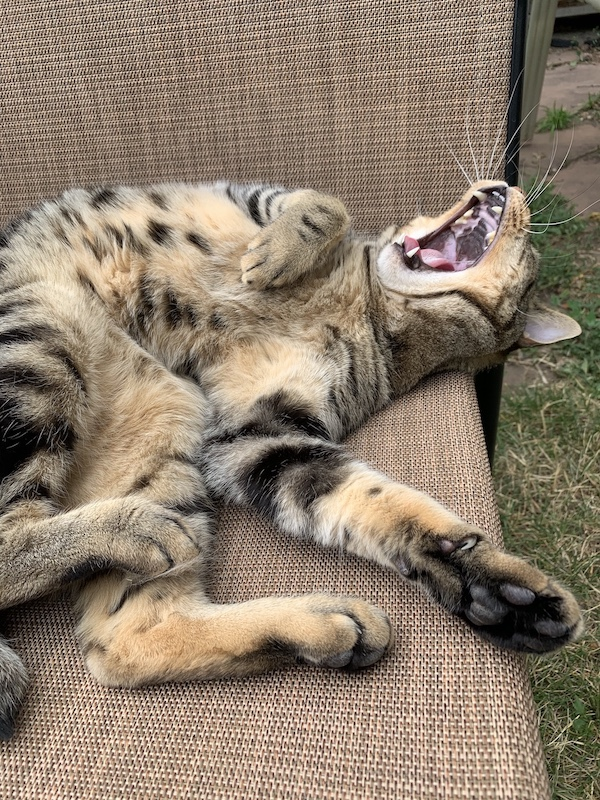

In [28]:
# === Merge image channels back together === #

# Rejoin with alpha channel that's always 1, or non-transparent
rgba = [b, g, r, a]
# Both of the lines below accomplish the same thing
im_4ch = cv2.merge(rgba, 4)
# im_4ch = np.stack([b, g, r, a], axis=2)

print(im_4ch.shape)
cv2_imshow(im_4ch)

BG shape: (800, 600, 4)
Mask shape: (800, 600, 4)


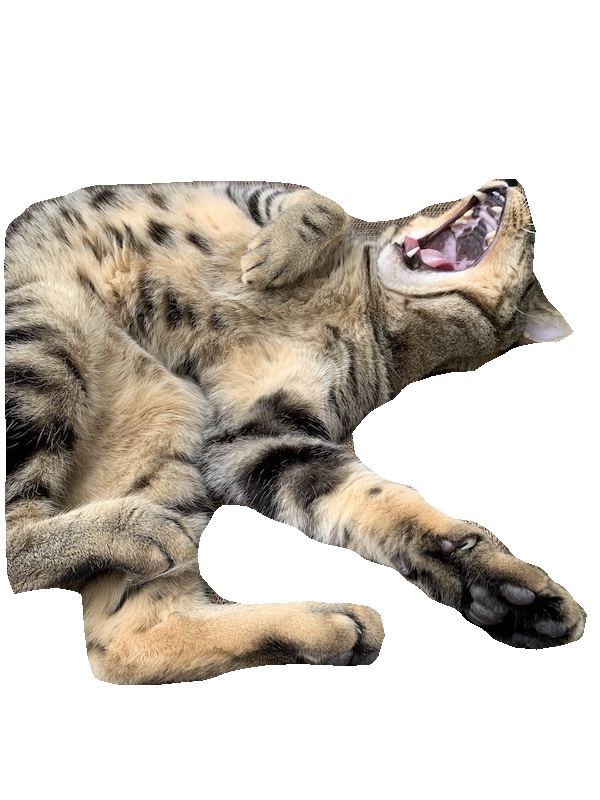

In [32]:
# === Extract pixels using mask === #

# Create 4-channel blank background
bg = np.zeros(im_4ch.shape)
print("BG shape:", bg.shape)

# Create 4-channel mask
mask = np.stack([hobbes_mask, hobbes_mask, hobbes_mask, hobbes_mask], axis=2)
print("Mask shape:", mask.shape)

# Copy color pixels from the original color image where mask is set
foreground = np.where(mask, im_4ch, bg).astype(np.uint8)

# Check out the result
cv2_imshow(foreground)

---

#### The Roundabout Method

This is that "second" method I talked about in the introduction.

This is how I added a fourth channel to the image after the fact, once the colored pixels had been copied onto a black background. While this method works, I'm sure you can think of one primary issue with it.

It took me too long to realize this, but by using a black background and the method below, which converts all black pixels to transparent, any pixels brought over from the original image that also happened to be black were converted to transparent.

That's why I decided to refactor into the method above.

However, I felt like I should leave it in anyways, as it still has some potentially useful code in it. For example, in the case when the image cannot be converted to four channels beforehand.

In [ ]:
# Create a blank black 3-channel background
bg = np.zeros(im.shape)
bg.shape

In [ ]:
# Create 3-channel mask
mask = np.stack([hobbes_mask, hobbes_mask, hobbes_mask], axis=2)

In [ ]:
# Copy color pixels from the original color image where mask is set
foreground = np.where(mask, im, bg).astype(np.uint8)

In [ ]:
# Convert to 4-channel image
# i.e. add the alpha channel and convert black pixels to alpha
tmp = cv2.cvtColor(foreground.astype("uint8"), cv2.COLOR_BGR2GRAY)
_, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
b, g, r = cv2.split(foreground.astype("uint8"))
rgba = [b, g, r, alpha]
dst2 = cv2.merge(rgba, 4)
# Look at the result, if needed
cv2_imshow(dst2)

---
---

## Image manipulation with Python

Now, this image can be saved (as a PNG to preserve the alpha channel/transparency) and simply overlayed onto another image. Or, even better, the image can be used directly (as it is now, in the form of an array), scaled, rotated, moved, then pasted overtop of the other image.

At first I was going to use Photoshop to overlay Hobbes and make him look like a super dangerous sharkitty. But then I remembered the goal of this post, and decided to do it programmatically with Python.

The primary library I'll be using to manipulate images is [Pillow](https://pillow.readthedocs.io/).

In [44]:
# === Import Pillow === #
from PIL import Image
# Use plt to display images
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
# === Download the background image === #
!wget https://raw.githubusercontent.com/tobias-fyi/assetstash/master/visual/images/img_seg_bin_mask/05_jaws_kinda.jpg -q -O 05_jaws_kinda.jpg

(600, 900)


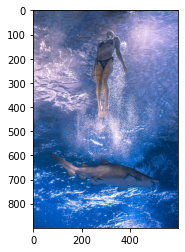

In [77]:
# === Load background image from file === #
jaws_img = Image.open("05_jaws_kinda.jpg")

# Dimensions of background image (600, 900) will be useful later
print(jaws_img.size)
plt.imshow(jaws_img)

---

### Rotation

In [57]:
# === Function to rotate custom amount === #
# Found here: https://stackoverflow.com/a/9042907/10589271
# There is another (potentially easier) way to do it with Pillow, using Image.rotate()
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

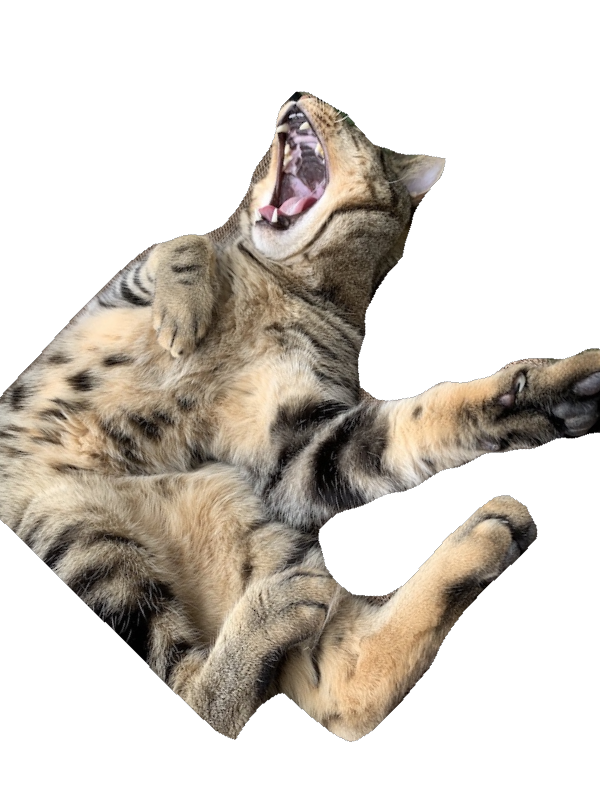

In [60]:
# === Rotate the foreground === #
fg_rotated = rotate_image(foreground, 45)
cv2_imshow(fg_rotated)

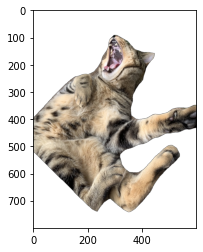

In [61]:
# === Load image into PIL.Image === #

# Convert color from BGRA to RGBA
fg_rotated_fixed = cv2.cvtColor(fg_rotated, cv2.COLOR_BGRA2RGBA)

# Load into PIL.Image from array in memory
hobbes_rotated = Image.fromarray(fg_rotated_fixed)

plt.imshow(hobbes_rotated)

---

### Crop

In an effort toward automating this process as much as possible, I'm going to crop the image based on the bounding box coordinates returned as part of the Detectron2 model output.

In [ ]:
# === Extract bounding box coordinates from model output === #


In [9]:
# Look at the outputs - classes and masks
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_masks)

tensor([16, 57, 57], device='cuda:0')
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False, 

In [10]:
# === Find out what the class IDs correspond to ===

# List of all classes in training dataset (COCO)
# predictor.metadata.as_dict()["thing_classes"]

# The one we are interested in
predictor.metadata.as_dict()["thing_classes"][16]

'dog'

In [11]:
# === Extract (only) the mask of Hobbes === #
# Find the index of the class we are interested in
# First, convert to numpy array to allow direct indexing
class_ids = np.array(outputs["instances"].pred_classes.cpu())
class_index = np.where(class_ids == 16)  # Find index where class ID is 16
# Use that index to index the array of masks
mask_tensor = outputs["instances"].pred_masks[class_index]
print(mask_tensor.shape)
mask_tensor

torch.Size([1, 800, 600])


tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')

In [21]:
# Convert tensor to numpy array
hobbes_mask = mask_tensor.cpu()
print("Before:", type(hobbes_mask))
print(hobbes_mask.shape)
hobbes_mask = np.array(hobbes_mask[0])
print("After:", type(hobbes_mask))
print(hobbes_mask.shape)

Before: <class 'torch.Tensor'>
torch.Size([1, 800, 600])
After: <class 'numpy.ndarray'>
(800, 600)


In [22]:
hobbes_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

(480, 420)


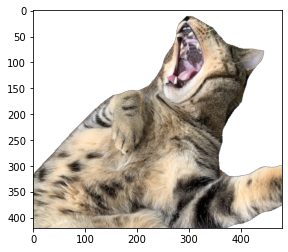

In [76]:
# === Crop === #
box2 = (0, 80, 480, 500)
crop2 = hobbes_rotated.crop(box2)
print(crop2.size)
plt.imshow(crop2)

(600, 525)


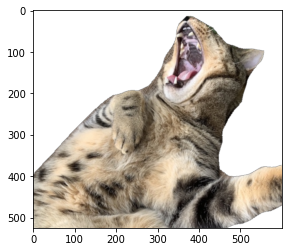

In [79]:
# === Scale up to match width === #
width = jaws_img.size[0]
scale = width / crop2.size[0]  # Calculate scale to match width
height = int(scale * crop2.size[1])  # Scale up height accordingly
new_size = (width, height)

# Resize!
resized = crop2.resize(new_size)
print(resized.size)
plt.imshow(resized)

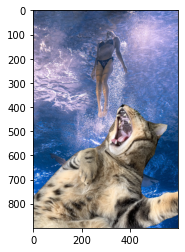

In [82]:
# === Paste onto background image === #
paws = jaws_img.copy()
# Paste box dimensions have to exactly match the image being pasted
paste_box = (0, paws.size[1] - resized.size[1], paws.size[0], paws.size[1])
paws.paste(resized, paste_box, mask=resized)
plt.imshow(paws)

In [85]:
# === Save the masterpiece to local filesystem === #
paws.save("06_paws.jpg")

---
---

## Final Thoughts

What a masterpiece!

<img src="https://raw.githubusercontent.com/tobias-fyi/assetstash/master/visual/images/img_seg_bin_mask/06_paws.jpg" width=300/>

### Improvements

The crop could be done automatically by extracting and using the coordinates of the bounding box from the model output.

### Further Work

I want to build a simple little web app and API that would allow anyone to upload an image, choose a class of object to extract (or remove), then download the image with the background (and/or other objects) removed.

Once I finish building that, I'll put a link here.